<a href="https://colab.research.google.com/github/Barathrajsbr/FaceRecognition/blob/master/FaceRecognitionsbr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install py-agender



In [0]:
!pip install fer

In [4]:
!pip install opencv-python

age = 19
gender = G_Female
Emotion = happy


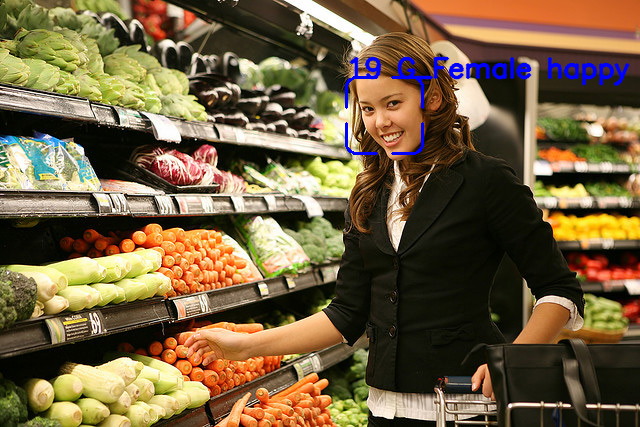

Color Information
[0.5613975903614458, 0.11732530120481928, 0.09633734939759037, 0.0956144578313253, 0.07269879518072289, 0.056626506024096385]
Color Bar


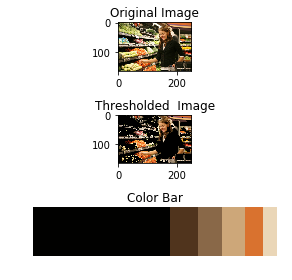

age = 36
gender = G_Female
Emotion = happy


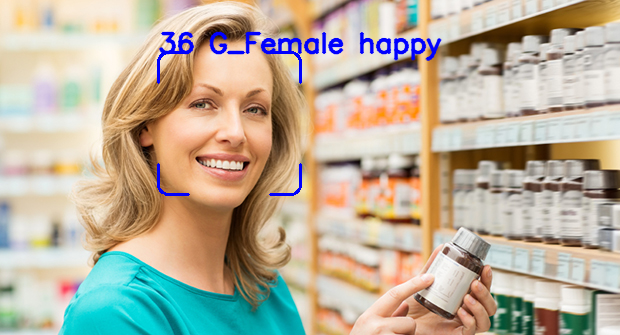

Color Information
[0.5613975903614458, 0.28182579564489113, 0.23926926298157453, 0.21199748743718594, 0.16593383584589616, 0.11732530120481928, 0.10097361809045226, 0.09633734939759037, 0.0956144578313253, 0.07269879518072289, 0.056626506024096385]
Color Bar


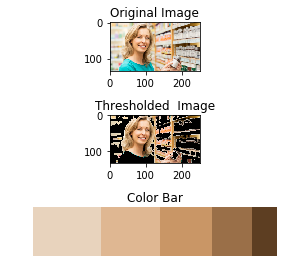

In [3]:
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot as plt
from pyagender import PyAgender
from fer import FER
import numpy as np
import imutils
import pprint
import cv2
import sys

font = cv2.FONT_HERSHEY_SIMPLEX
face_cascade = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml") #classifier
# img = cv2.imread("/content/sample22.jpg")
# img = cv2.imread("/content/sample108.jpg") 

def faceR(addr):
  img = cv2.imread(addr)   #gets the image as input
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    #grayscale image
  faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.05, minNeighbors=5)
  def draw_border(img, pt1, pt2, color, thickness, r, d):
      x1,y1 = pt1
      x2,y2 = pt2

      # Top left
      cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
      cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
      cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)

      # Top right
      cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
      cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
      cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)

      # Bottom left
      cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
      cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
      cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)

      # Bottom right
      cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
      cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
      cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)

  # displaying rectangle
  for x, y, w, h in faces[:2]:
    draw_border(img, (x,y), (x+w,y+h), (255,0,0), 2, 10, 20)

  #     img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

  org = (x, y) 
  fontScale = 0.9
  color = (255,0,0)
  thickness = 2

  count = 0
  for x in list(faces[:]):
      agender = PyAgender()
      faces = agender.detect_genders_ages(img)
      gender = faces[count]['gender']
      count = count + 1
      age = int(faces[0]['age'])
      gender= 'G_Male' if (gender < 0.5) else 'G_Female'
      print('age =',age)
      print('gender =', gender)
      detector = FER()
      result = detector.top_emotion(img)
      print('Emotion =',result[0])


  image = cv2.putText(img, str(age)+" "  + gender+ " "  + str(result[0]), org, font, fontScale,  
                   color, thickness, cv2.LINE_AA, False) 
  #displaying image
  cv2_imshow(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()




def extractSkin(image):
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR)


def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)


def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):

        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation


def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
        def detection(color):
            print(color)
#         if(color==(1, 1, 0)):
#           print('black')
#         print(color)
#         if(color==(232, 211, 189)):
#           print('American')
        
    return color_bar


"""## Section Two.4.2 : Putting it All together: Pretty Print
The function makes print out the color information in a readable manner
"""

getcolor =list()
def prety_print_data(color_info):
    for x in color_info:
#         print(pprint.pformat(x))
# #         print(pprint.pformat(x['color']))
#         print(pprint.pformat(x['color_percentage']))
        getcolor.append(x['color_percentage'])
#         print()
    result = getcolor.sort(reverse=True)
    print(getcolor)
    
def skindetectFR(addr):
  # Get Image from URL. If you want to upload an image file and use that comment the below code and replace with  image=cv2.imread("FILE_NAME")
  image =cv2.imread(addr)
  # image =cv2.imread("/content/sample22.jpg")
  # Resize image to a width of 250
  image = imutils.resize(image, width=250)

  # Show image
  plt.subplot(3, 1, 1)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title("Original Image")
  # plt.show()

  # Apply Skin Mask
  skin = extractSkin(image)

  plt.subplot(3, 1, 2)
  plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
  plt.title("Thresholded  Image")
  # plt.show()

  # Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
  dominantColors = extractDominantColor(skin, hasThresholding=True)

  # Show in the dominant color information
  print("Color Information")
  prety_print_data(dominantColors)

  # Show in the dominant color as bar
  print("Color Bar")
  colour_bar = plotColorBar(dominantColors)
  plt.subplot(3, 1, 3)
  plt.axis("off")
  plt.imshow(colour_bar)
  plt.title("Color Bar")

  plt.tight_layout()
  plt.show()
 

if __name__=='__main__':
  image_Addr=sys.argv[1]
  path='/content/sample108.jpg'
  path1 ='/content/sample38.jpg'
  faceR(path)
  skindetectFR(path)
  faceR(path1)
  skindetectFR(path1)
#   faceR('/content/sample38.jpg')
